# Load Video Signal

In [1]:
import cv2
import numpy as np
from scipy import stats
from scipy.fftpack import fft
from extractor import qifft
import scipy
from scipy import signal
from scipy.signal import resample
import os
from matplotlib import pyplot as plt
from video import Video
from database import db # We do not provide our database for security reasons. 
# Instead, we will provide some ground truth reference ENF signals. 

##### Please read this comment! 
# ***You might not be able to run "enf_ref"&"enf_ref_day" because they are the ground-truth ENF collected 
# directly from the power grid using the FDR (Frequency Disturbance Recorder).
# our lab has installed the FDR and has been collecting the ENF and storing it in the database.
# It takes some time because it loads the 24-hours real-time ENF data from the ENF database
# Therefore, it will be more convinient to refer other jupyter file
# "(SPL)Phase-based_ENF_estimation+time-estimation_(using_stored_ground_truth_ENF)" 
# that uses a sample groud-truth ENF stored in our database.

# FILENAME = 'powershot_20210923_195431.MP4' 
# enf_ref = db.get_enf(1,'2021-09-23 19:54:34','2021-09-23 19:56:34')

# FILENAME = 'powershot_20210923_184700.MP4' 
# enf_ref = db.get_enf(1,'2021-09-23 18:47:02','2021-09-23 18:49:02')

# FILENAME = 'zflip_20210921_122229.mp4' 
# enf_ref = db.get_enf(1,'2021-09-21 12:22:29','2021-09-21 12:24:29')

# FILENAME = 'zflip_20210925_151340.mp4'
# enf_ref = db.get_enf(1,'2021-09-25 15:13:41','2021-09-25 15:15:41')

# FILENAME = 'surfacerear_20210919_151900.mp4'
# enf_ref = db.get_enf(1,'2021-09-19 15:19:01','2021-09-19 15:21:01')

# FILENAME = 'surfacefront_20210919_153500.mp4' 
# enf_ref = db.get_enf(1,'2021-09-19 15:35:00','2021-09-19 15:37:00')

FILENAME = 'ipad_20210919_165700.MOV' 
enf_ref = db.get_enf(1,'2021-09-19 16:57:00','2021-09-19 16:59:00')

# FILENAME = 'ipad_20210919_171030.MOV'
# enf_ref = db.get_enf(1,'2021-09-19 17:10:30','2021-09-19 17:12:30')

# FILENAME = 'iphone12pro_20210917_135800.mov' 
# enf_ref = db.get_enf(1,'2021-09-17 13:58:00','2021-09-17 14:00:00')

# FILENAME = 'iphone12pro_20210917_155830.MP4'
# enf_ref = db.get_enf(1,'2021-09-17 15:58:32','2021-09-17 16:00:32')

enf_ref = np.array(enf_ref) # ENF from video data
t_ref = enf_ref[:,1]
enf_ref = enf_ref[:,0]
fs_ref = 10


MAX_FRAME_N = 1000
SEP = os.path.sep

FOLDER = '/home/cho/Desktop/hyekyung/video/static/'
PATH = FOLDER + FILENAME
video = Video(PATH)

## when running for the first time
# cut the video into 2 minutes (2 sec~ 122 sec)
# F_ST = int(video.fps*(2*1))  
# F_ED = int(video.fps*(122*1)) 
# video.set_vector(F_ST, F_ED) 
# video.save_vector()

video.load_vector() # load video signal(row signal)

File  Name : /home/cho/Desktop/hyekyung/video/static/ipad_20210919_165700.MOV
Total Frame: 3721
Frame Size : 1280 x 720
FPS        : 29.984689
File cannot be loaded


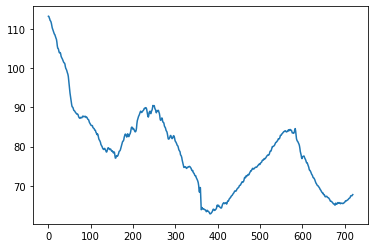

In [2]:
# Raw video signal
mat = video.vec
plt.plot(mat[0]);plt.show()

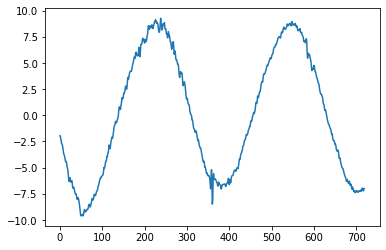

In [3]:
# Row signal
mat = video.vec - video.vec.mean(0)
mat = mat - mat.mean(1)[:,None]
plt.plot(mat[0])

# Calculating $T_{ro}$

In [5]:
N = mat.shape[0]
D = mat.shape[1]
f0 = 120

N_ripple=np.zeros((N))
for i_frame in range(N):
    y = mat[i_frame,:]
    y_fft = 20*np.log10(np.abs(np.fft.fft(y))) # Compute the one-dimensional discrete Fourier Transform.
    y_fft = y_fft[0:int(D/2+1)]
    i = np.argmax(y_fft)
    p = 0.5 * (y_fft[i-1]-y_fft[i+1])/(y_fft[i-1]-2*y_fft[i]+y_fft[i+1])
    N_ripple[i_frame] = i+p

<ipython-input-5-9d4ac1965905>:8: RuntimeWarning: divide by zero encountered in log10
  y_fft = 20*np.log10(np.abs(np.fft.fft(y))) # Compute the one-dimensional discrete Fourier Transform.


In [6]:
N_ripple[np.where(np.isnan(N_ripple))]=0
N_ripple = np.sum(N_ripple)/np.sum(N_ripple != 0)

T_ro = N_ripple/(f0)
f_s = (f0*D)/N_ripple
M = int(D/(T_ro*video.fps))
print(D,M)

720 1404


## Gradient Descent parameter estimation (fitting the row signal)

In [7]:
%matplotlib notebook

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

def J(y,A,phi,f,d):
    D = len(y)
    i = np.arange(D)
    tmp = 2*np.pi*f/f_s
    return (1/2*D)*(y-A*np.sin(tmp*i+phi)-d)**2

def dJdA(y,A,phi,f,d):
    D = len(y)
    i = np.arange(D)
    tmp = 2*np.pi*f/f_s
    dev = (y-A*np.sin(tmp*i+phi)-d)*(-np.sin(tmp*i+phi))
    return (1/D)*dev.sum()

def dJdphi(y,A,phi,f,d):
    D = len(y)
    i = np.arange(D)
    tmp = 2*np.pi*f/f_s
    dev = (y-A*np.sin(tmp*i+phi)-d)*(-A*np.cos(tmp*i+phi))
    return (1/D)*dev.sum()

def dJdf(y,A,phi,f,d):
    D = len(y)
    i = np.arange(D)
    tmp = 2*np.pi*f/f_s
    dev = (y-A*np.sin(tmp*i+phi)-d)*(-A*np.cos(tmp*i+phi))*2*np.pi*i/f_s
    return (1/D)*dev.sum()

def dJdd(y,A,phi,f,d):
    D = len(y)
    i = np.arange(D)
    tmp = 2*np.pi*f/f_s
    dev = (y-A*np.sin(tmp*i+phi)-d)*(-1)
    return (1/D)*dev.sum()

def grad_vec(y,A,phi,f,d):
    return np.array([dJdA(y,A,phi,f,d), dJdphi(y,A,phi,f,d), dJdf(y,A,phi,f,d), dJdd(y,A,phi,f,d)])

def calc_diff(y,theta,f_s):
    t = np.arange(len(y))
    z = theta[0]*np.sin((2*np.pi*theta[2]/f_s)*t+theta[1])+theta[3]
    squared_sum = ((y-z)**2).sum()
    mse = squared_sum/len(y)
    rmse = np.sqrt(mse)
    nrmse = rmse/(y.max()-y.min())
#    return np.sqrt(((y-z)**2).mean())
    return nrmse


def grad_descent(y, theta, f_s, learning_rate):

    epsilon = 0.00001 #new threshold for normalized RMSE
    threshold = 0.07
    max_iteration = 1000
    D = len(y)

    # initial diff
    diff = calc_diff(y,theta,f_s)

    # First iteration of gradient descent
    theta_next = theta - learning_rate*grad_vec(y, theta[0], theta[1], theta[2], theta[3])
    diff0ext = calc_diff(y,theta_next,f_s)
    
    cnt = 0
    A_history = [theta[0], theta_next[0]]
    phi_history = [theta[1], theta_next[1]]
    f_history = [theta[2], theta_next[2]]
    d_history = [theta[3], theta_next[3]]
    diff_history = [diff, diff0ext]
    
    while cnt < max_iteration:
        theta = theta_next
        theta_next = theta-learning_rate*grad_vec(y, theta[0], theta[1], theta[2], theta[3])
        
        diff = calc_diff(y,theta,f_s)
        diff0ext = calc_diff(y,theta_next,f_s)

        if np.abs(diff - diff0ext) < epsilon and diff0ext < threshold:
            break        
        
        # save parameters
        A_history = np.append(A_history, theta_next[0])
        phi_history = np.append(phi_history, theta_next[1])
        f_history = np.append(f_history, theta_next[2])
        d_history = np.append(d_history, theta_next[3])
        diff_history = np.append(diff_history, diff0ext)
        cnt+=1

    return (A_history, phi_history, f_history, d_history, diff_history)
#     return theta_next

N = mat.shape[0]
D = mat.shape[1]


y = mat[0,:]
theta_init = [abs(max(y)-min(y))/2, np.pi, 120, (max(y)+min(y))/2]


f0 = 120
E_dp = 2*np.pi*f0/video.fps


params = np.zeros((N,4)) # A, phi, f, d

learning_rate_init = [0.5, 0.01, 0.5, 0.5]
learning_rate_iter = [0.01, 0.01, 0.01, 0.5]


plot_verbose = False # if True, animation of the optimization process will be showed.
# i_frame=0

if 'i_frame' not in globals():
    i_frame = 0


if plot_verbose:
    
    y = mat[i_frame,:]
    
    if i_frame == 0:
        learning_rate = learning_rate_init
    else:
        learning_rate = learning_rate_iter
        
    history_next = grad_descent(y, theta_init, f_s, learning_rate)
    
    theta_init = [history_next[0][-1],history_next[1][-1]+E_dp,history_next[2][-1],history_next[3][-1]]

    plt.rcParams["figure.figsize"] = (8,6)
    fig, ax = plt.subplots()
    ax.set_xlim((0, len(y)))
    ax.set_ylim((-17, 15))
#     ax.set_ylim((-1.5, 0.5))
    line, = ax.plot([], [], lw=2)
    line2, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], lw=2)
    line4, = ax.plot([], [], lw=2)
    plt.legend(['y','y_hat','RMSE(y,y_hat)','phi'])

    diff_hist = []
    
    def init():
        line.set_data([], [])
        line2.set_data([], [])
        line3.set_data([], [])
        line4.set_data([], [])
        return (line,line2,line3,line4)

    def animate(i):
        t = np.arange(D)
        f = history_next[2][i]
        params = (2*np.pi*f/f_s)*t

        z = history_next[0][i]*np.sin(params+history_next[1][i])+history_next[3][i]
        line.set_data(t, y)
        line2.set_data(t, z)
        line3.set_data(t[:i], history_next[4][:i])
        line4.set_data(t[:i], np.mod(history_next[1][:i],2*np.pi))

        return (line,line2,line3,line4)

    step = 1
    N_history = len(history_next[0])
    steps = np.arange(0,N_history,step)
    anim = animation.FuncAnimation(fig, animate, steps, init_func=init, interval=100, blit=True)
    
    t = np.arange(D)
    f = history_next[2][i]
    params = (2*np.pi*f/f_s)*t
    i = len(history_next[0])-1
    z = history_next[0][i]*np.sin(params+history_next[1][i])+history_next[3][i]
    plt.plot(t,z)
    plt.plot(t,y)
    line3.set_data(t[:i], history_next[4][:i])
    line4.set_data(t[:i], np.mod(history_next[1][:i],2*np.pi))

    i_frame = i_frame+1
    
else:
    for i_frame in tqdm(range(N)):
        y = mat[i_frame,:]
        if i_frame == 0:
            learning_rate = learning_rate_init
        else:
            learning_rate = learning_rate_iter
        history_next = grad_descent(y, theta_init, f_s, learning_rate)
        
        params[i_frame] = [history_next[0][-1],history_next[1][-1],history_next[2][-1],history_next[3][-1]]
        theta_init = [history_next[0][-1],history_next[1][-1]+E_dp,history_next[2][-1],history_next[3][-1]]

params_gd = params

100%|██████████| 3599/3599 [00:03<00:00, 1018.86it/s]


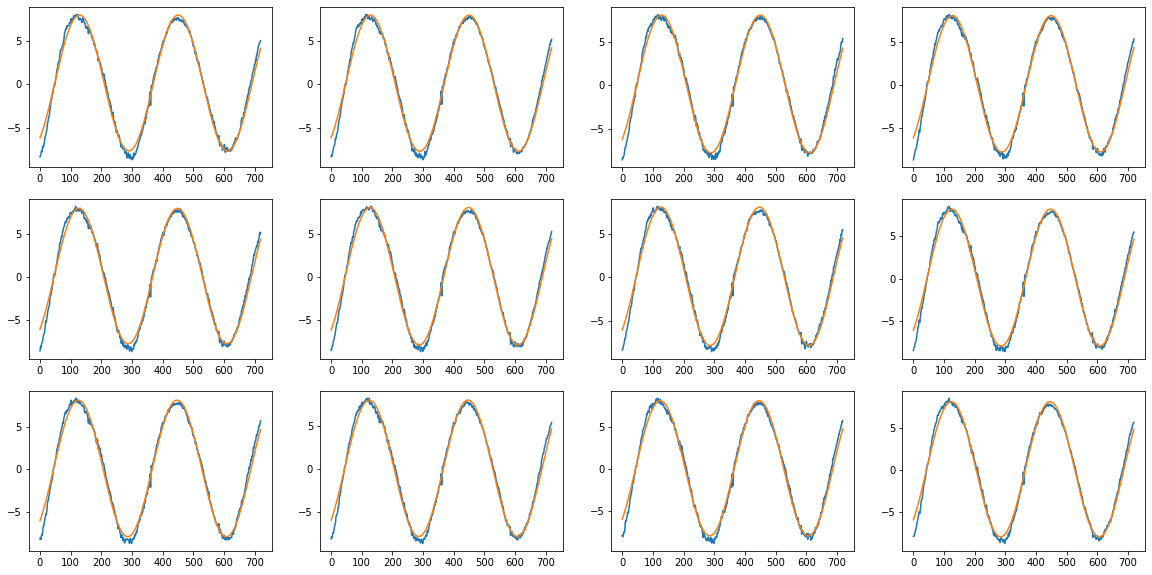

In [8]:
%matplotlib inline
for i,i_frame in enumerate(np.arange(12)+23*int(video.fps)):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.subplot(3,4,i+1)
    y = mat[i_frame,:]
    theta = params_gd[i_frame,:]
    t = np.arange(len(y))
    z = theta[0]*np.sin((2*np.pi*theta[2]/f_s)*t+theta[1])+theta[3]
    plt.plot(t,y)
    plt.plot(t,z)
plt.show()

## pre-setting

window size ($n\_w$)
- estimate a frequency at single frame with $n\_w$

overlap size ($n\_ol$)  
- overlap of window size

stride size ($n\_st$)  
- $n\_w - n\_ol$

In [9]:
t_w = 1 # same windowing of 1 second
n_w = int(video.fps*t_w)
t_st = 0.5 # 0.5 stride
n_st = int(video.fps*t_st)
n_ol = n_w - n_st

n_frame = mat.shape[0]
n_rst = np.floor((n_frame-n_w)/n_st).astype('int')
idx_st = np.arange(n_w)
idx_repeat = n_st * np.arange(n_rst)
idx_sliding = idx_st[None,:] + idx_repeat[:,None]
idx_sliding = idx_sliding.astype('int')
fs_sliding = 1/n_st*video.fps

# enf_ref scaling
Appling the same windowing of 1 sec for accurate RMSE comparison including the reference ENF data.

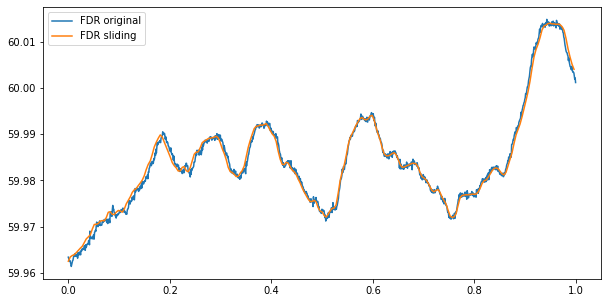

In [10]:
enf_refu = signal.resample(enf_ref, video.vec.shape[0])
enf_refu = enf_refu[idx_sliding].mean(1)
enf_refu = enf_refu[1:]
fs_refu = fs_sliding
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(np.arange(len(enf_ref))/len(enf_ref),enf_ref)
plt.plot(np.arange(len(enf_refu))/len(enf_refu),enf_refu)
plt.legend(['FDR original','FDR sliding'])

# State-of-the-art methods for ENF extraction

## Spectrogram-based methods

## QIFFT 

In [11]:
from extractor import qifft
y = np.reshape(mat,-1)
Fs = video.fps * video.n_t
ext = qifft.Extractor(y, Fs, nFFT=int(Fs*t_w), n_ol=int(Fs*(t_w-t_st)))
enf_q, fs_q = ext.extract(60, [120])
enf_q = enf_q[1:]

## Weighted Energy

In [12]:
from extractor import WE
y = np.reshape(mat,-1)
Fs = video.fps * video.n_t
ext = WE.Extractor(y, Fs, nFFT=int(Fs*t_w), n_ol=int(Fs*(t_w-t_st)))
enf_w, fs_w = ext.extract(60, [120])
enf_w = enf_w[1:]

## QIFFT + Periodic Zero-padding

In [13]:
from extractor import qifft
zero_pad = np.zeros((mat.shape[0],M-D))
y = np.hstack((mat,zero_pad)) # NxL -> Nx[L|0] -> NxM (zero padding)
y = np.reshape(y,-1)
# Fs = video.fps * video.n_t
Fs = video.fps * M
ext = qifft.Extractor(y, Fs, nFFT=int(Fs*t_w), n_ol=int(Fs*(t_w-t_st)))
enf_z, fs_z = ext.extract(60, [120])
enf_z = enf_z[1:]

## HGD-frequency 
using optimized frequency from the HGD

In [14]:
freqs = params_gd[:,2]

rst = np.zeros(n_rst)
for i in range(idx_sliding.shape[0]):
    idx_s = idx_sliding[i,:]
    rst[i] = freqs[idx_s].mean()
    
enf_gf = rst[1:]
fs_gf = fs_sliding

# Phase-based ENF estimation

## Subspace-based methods

## MUSIC

In [15]:
def MUSIC(CovMat, L, M, Fe):
    R=np.asmatrix(CovMat)
    U,S,V=np.linalg.svd(R)
    G=U[:,L:]
    P=G*G.H
    Q=0j*np.zeros(2*M-1)
    for (idx,val) in enumerate(range(M-1,-M,-1)):
        diag=np.diag(P,val)
        Q[idx]=np.sum(diag)
    roots=np.roots(Q)
    roots=np.extract(np.abs(roots)<1,roots)
    roots=np.extract(np.imag(roots) != 0,roots)
    distance_from_circle=np.abs(np.abs(roots)-1)
#    print(distance_from_circle)
    index_sort=np.argsort(distance_from_circle)
    component_roots=roots[index_sort[:L]]
    angle=-np.angle(component_roots)
    f=Fe*angle/(2.*np.pi)
    
    return f

rst = np.zeros(n_rst)

for i in tqdm(range(idx_sliding.shape[0])):
    idx_s = idx_sliding[i,:]
    CovMat = np.cov(mat[idx_s,:])
    f_raw = np.abs(MUSIC(CovMat,2,idx_sliding.shape[1],video.fps))[0]
    sign_Edp = +1 if np.mod(E_dp,2*np.pi) < np.pi else -1
    rst[i] = f_raw * sign_Edp
    
enf_m = rst[1:]
fs_m = fs_sliding

100%|██████████| 255/255 [00:00<00:00, 640.67it/s]


## ESPRIT

In [16]:
import scipy.linalg as LA

def ESPRIT(CovMat,L,N):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    _,U = LA.eig(CovMat)
    S = U[:,0:L]
    Phi = LA.pinv(S[0:N-1]) @ S[1:N] # the original array is divided into two subarrays [0,1,...,N-2] and [1,2,...,N-1]
    eigs,_ = LA.eig(Phi)

    DoAsESPRIT = np.arcsin(np.angle(eigs)/np.pi)[0]
    sign_Edp = +1 if np.mod(E_dp,2*np.pi) < np.pi else -1

    return DoAsESPRIT*sign_Edp

rst = np.zeros(n_rst)

for i in tqdm(range(idx_sliding.shape[0])):
    idx_s = idx_sliding[i,:]
    CovMat = np.cov(mat[idx_s,:])
    rst[i] = ESPRIT(CovMat,2,idx_sliding.shape[1])
    
    
enf_e = rst[1:]
fs_e = fs_sliding

100%|██████████| 255/255 [00:00<00:00, 3380.15it/s]


## HGD-phase (the proposed method using optimized phase from HGD algorithm)

In [17]:
# phis = np.array([item[1][-1] for item in history])
phis = params_gd[:,1]

# E_dp = 2*np.pi*f0/video.fps
# E_dp = np.mod(E_dp,2*np.pi)

x = phis
x = x - E_dp*np.arange(len(x))
x = np.diff(x,1)

rst = np.zeros(n_rst)
for i in range(idx_sliding.shape[0]):
    idx_s = idx_sliding[i,:]
    rst[i] = x[idx_s].mean()

enf_p = rst[1:]
fs_gp = fs_sliding

## normalization for eval.

In [18]:
def eval_norm(enf):
    return (enf-enf.mean())/enf.std()

## Evaluation - resample

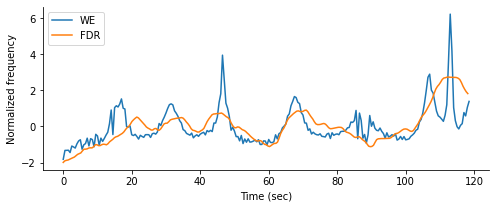

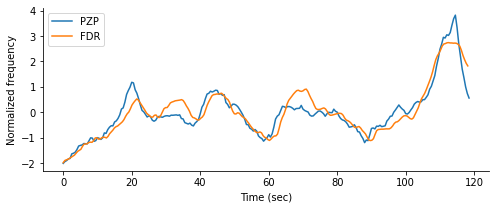

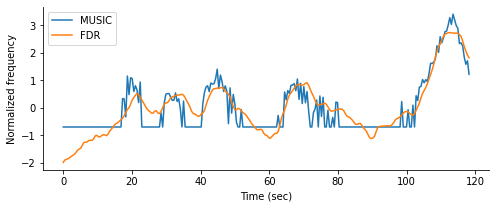

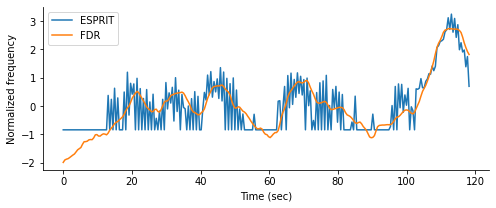

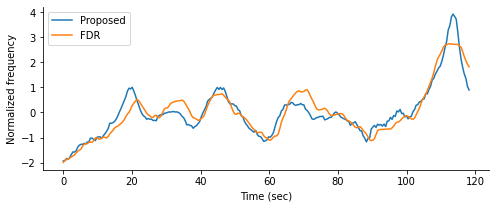

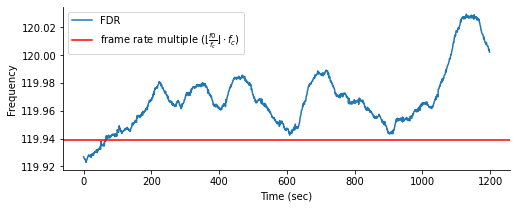

In [19]:
figs_folder = 'new_figs/'+FILENAME
# figs_folder = 'motion_figs/'+FILENAME
if not os.path.exists(figs_folder): 
    os.mkdir(figs_folder)
figs_format = '.eps'
    
%matplotlib inline
time_shift = 0

set_size = (8,3)
fig, ax = plt.subplots(figsize=set_size)
method = 'WE'
ax.plot(np.arange(len(enf_w))/fs_w+time_shift,eval_norm(enf_w))
ax.plot(np.arange(len(enf_refu))/fs_refu,eval_norm(enf_refu))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time (sec)')
plt.ylabel('Normalized frequency')
plt.legend([method,'FDR'])
plt.show()

fig, ax = plt.subplots(figsize=set_size)
method = 'PZP'
ax.plot(np.arange(len(enf_z))/fs_z+time_shift,eval_norm(enf_z))
ax.plot(np.arange(len(enf_refu))/fs_refu,eval_norm(enf_refu))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time (sec)')
plt.ylabel('Normalized frequency')
plt.legend([method,'FDR'])
plt.show()

fig, ax = plt.subplots(figsize=set_size)
method = 'MUSIC'
ax.plot(np.arange(len(enf_m))/fs_e+time_shift,eval_norm(enf_m))
ax.plot(np.arange(len(enf_refu))/fs_refu,eval_norm(enf_refu))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time (sec)')
plt.ylabel('Normalized frequency')
plt.legend([method,'FDR'])
plt.show()

fig, ax = plt.subplots(figsize=set_size)
method = 'ESPRIT'
ax.plot(np.arange(len(enf_e))/fs_e+time_shift,eval_norm(enf_e))
ax.plot(np.arange(len(enf_refu))/fs_refu,eval_norm(enf_refu))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time (sec)')
plt.ylabel('Normalized frequency')
plt.legend([method,'FDR'])
plt.show()

fig, ax = plt.subplots(figsize=set_size)
method = 'Proposed'
ax.plot(np.arange(len(enf_p))/fs_e+time_shift,eval_norm(enf_p))
ax.plot(np.arange(len(enf_refu))/fs_refu,eval_norm(enf_refu))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time (sec)')
plt.ylabel('Normalized frequency')
plt.legend([method,'FDR'])
plt.show()

fig, ax = plt.subplots(figsize=set_size)
ax.plot(2*enf_ref, label="FDR")
ax.axhline(video.fps*4,color='red',label=r'frame rate multiple ($\lfloor {\frac{f0}{f_c}} \rfloor \cdot f_c)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.legend()

from matplotlib.ticker import ScalarFormatter
y_formatter = ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
plt.show()

## Normalized RMSE results

In [20]:
from scipy import signal

def rmse(enf_refu, enf_target):
    enf_refu_res = signal.resample(enf_refu,len(enf_target))
    return np.linalg.norm(eval_norm(enf_target)-eval_norm(enf_refu_res))

print(FILENAME)
print("{:.4f}\t{:.4f}".format(rmse(enf_refu,enf_w),rmse(enf_refu,enf_z)))
print("{:.4f}\t{:.4f}\t{:.4f}".format(rmse(enf_refu,enf_m),rmse(enf_refu,enf_e),rmse(enf_refu,enf_p)))
print("[{:.8f}]".format(np.mod(E_dp,2*np.pi)))

ipad_20210919_165700.MOV
13.5421	6.2222
7.8425	9.4977	5.9331
[0.01283317]
